# Introduction to Bayesian Statistics

## T-test example

Let's start with a simple example:

Two groups of people took an IQ test.

- Group 1, $N_1=47$, consumed a "smart drug"
- Group 2, $N_2=42$, is a control group that consumed a placebo


In [109]:
library(tidyverse)

In [110]:
smart = tibble(IQ = c(101,100,102,104,102,97,105,105,98,101,100,123,105,103,
                      100,95,102,106,109,102,82,102,100,102,102,101,102,102,
                      103,103,97,97,103,101,97,104,96,103,124,101,101,100,
                      101,101,104,100,101),
               Group = "SmartDrug")

placebo = tibble(IQ = c(99,101,100,101,102,100,97,101,104,101,102,102,100,105,
                        88,101,100,104,100,100,100,101,102,103,97,101,101,100,101,
                        99,101,100,100,101,100,99,101,100,102,99,100,99),
                 Group = "Placebo")

TwoGroupIQ <- bind_rows(smart, placebo)  %>%
    mutate(Group = fct_relevel(as.factor(Group), "Placebo"))

In [111]:
TwoGroupIQ %>%
  group_by(Group) %>%
  summarise(mean = mean(IQ)) %>%
  mutate(across(where(is.numeric), round, 2))

`summarise()` ungrouping output (override with `.groups` argument)



,Group,mean
,<fct>,<dbl>
1,Placebo,100.36
2,SmartDrug,101.91


In [112]:
library(tidybayes)
library(patchwork)

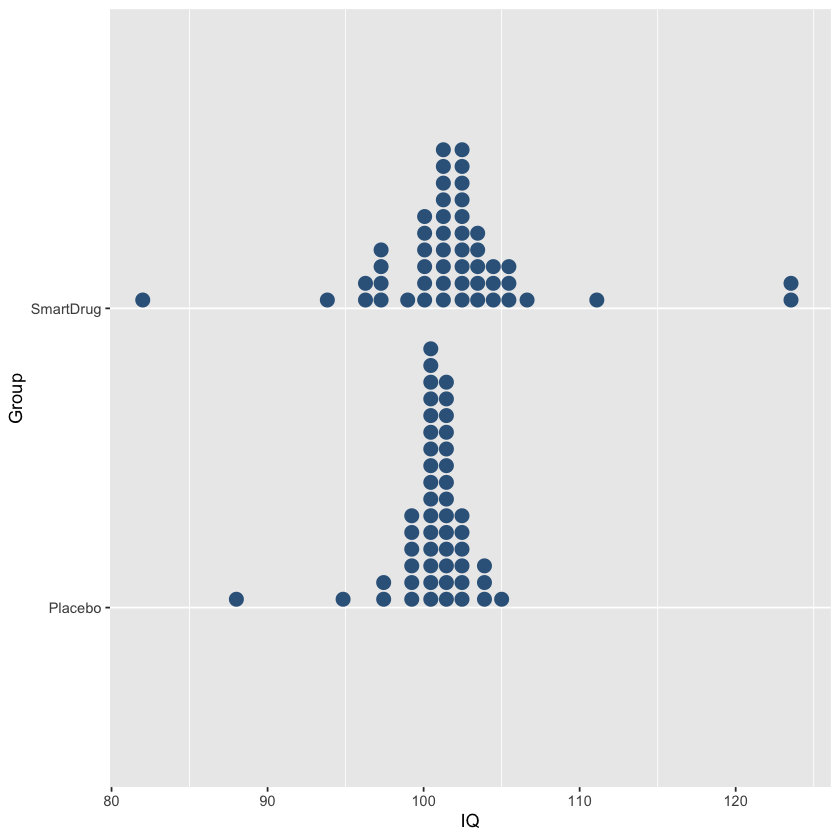

In [113]:
TwoGroupIQ %>%
   ggplot(aes(x = IQ, y = Group)) +
    stat_dotsh(position = "dodge", quantiles = 50, 
               color = NA, fill = "steelblue4") +
      labs(y = "Group", x = "IQ") +
      theme(panel.grid.major.x = element_blank())

## Two sample t-test / Welch test

We can perform a two-sample t-test, or a Welch test:

In [114]:
t.test(IQ ~ Group,
       data = TwoGroupIQ,
       var.equal = FALSE,
       alternative = "less")


	Welch Two Sample t-test

data:  IQ by Group
t = -1.6222, df = 63.039, p-value = 0.05488
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf 0.04532157
sample estimates:
  mean in group Placebo mean in group SmartDrug 
               100.3571                101.9149 


## Summary

What are we actually doing here?

### Inference

When we do a t test, we first estimate the group means; the maximum likelihood estimates are the sample means. We can then compute, or rather estimate, the difference between the groups **This is the inference part**.


We then divide the difference by a measure of the groups standard deviations, to give a t value.

In [115]:
means <- TwoGroupIQ %>%
  group_by(Group) %>%
  summarize(mean = mean(IQ),
           var = var(IQ),
           n = n(),
           s = var/n)
means

`summarise()` ungrouping output (override with `.groups` argument)



,Group,mean,var,n,s
,<fct>,<dbl>,<dbl>,<int>,<dbl>
1,Placebo,100.3571,6.332753,42,0.1507798
2,SmartDrug,101.9149,36.253469,47,0.7713504


In [116]:
means %>%
select(-var, -n) %>%
    pivot_wider(names_from = Group, values_from = c(mean, s)) %>%
    summarize(difference = mean_Placebo - mean_SmartDrug,
              s = sqrt(s_Placebo + s_SmartDrug),
              t = difference/s)

difference,s,t
<dbl>,<dbl>,<dbl>
-1.557751,0.9602761,-1.62219


### Hypothesis Test
Once we have the t value (and the degrees of freedom), we can compute the tail probability of obtaining a value at least as extreme.

In [117]:
pt(-1.62219, df = 63.039)

[1] 0.05487695

> It is important to realize that we are first doing parameter estimation, and then hypothesis testing.

## What does the p-value mean?

- Statement by American Statistical Association (ASA) about p-values.

   + P-values can indicate how incompatible the data are with a specified statistical model.

   + P-values do not measure the probability that the studied hypothesis is true (we would actually like to know this), or the probability that the data were produced by chance.


- The concept of null hypothesis significance testing (NHST) has been repeatedly critiqued
- p values are often mis-interpreted
- confidence intervals are often mis-interpreted

Why use them?
- Learning something new requires serious effort
- The procedure is standard, therefore I feel safe (ritualistic)
-It's difficult (software)


## Bayesian methods


🤗

- more intuitive (uncertainty) and based on probability theory

- provide evidence for/against hypotheses

- more flexible: robust models and cognitive process models 

- can include prior knowledge

- better for multilevel models

<br>
😧

- require computing power

- setting priors requires familiarity with probability distributions

- ongoing discussion about parameter estimation vs. hypothesis testing. See e.g.  [here](https://statmodeling.stat.columbia.edu/2017/05/04/hypothesis-testing-hint-not-think/) and [here](https://statmodeling.stat.columbia.edu/2011/04/02/so-called_bayes/).



## Questions that Bayesian methods can answer

- What is the probability that a parameter lies within a certain range?
- What is the probability that a parameter is less than a given number?
- What is the relative support for one model over another model?


## Quantifying uncertainty

- The essential characteristic of Bayesian methods is their use of probability for quantifying uncertainty in inferences based on data.

- This facilitates a common-sense interpretation of statistical conclusions.

<br>

The figure shows a frequentist confidence interval (OLS model) and a Bayesian credible interval. Which one is easier to interpret?

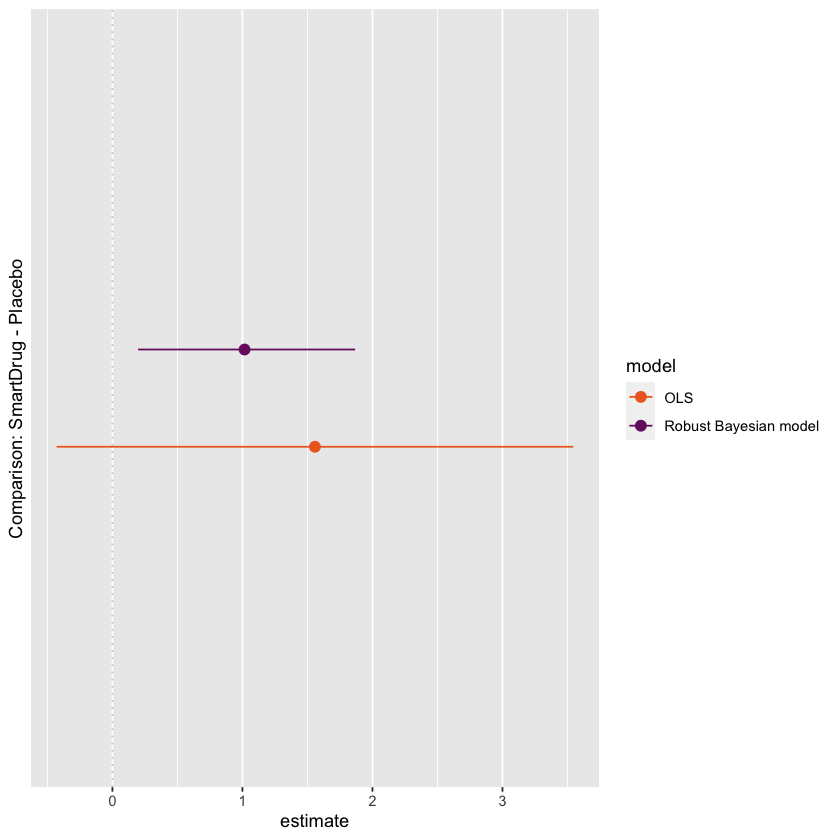

In [118]:
suppressWarnings(library(ggstance))
fit_robust_1 <- readRDS("models/fit_iq-robust_1.rds")

fit_ols <- lm(IQ ~ Group,
              data = TwoGroupIQ)

d <- broom::tidy(fit_ols, conf.int = TRUE) %>%
    mutate(
        low = estimate - std.error,
        high = estimate + std.error)

linear_results <- fit_ols %>%
    broom::tidy(conf.int = TRUE) %>%
    filter(term == "GroupSmartDrug") %>%
    mutate(model = "OLS")

bayes_results <- fit_robust_1 %>%
    spread_draws(b_GroupSmartDrug, b_GroupPlacebo) %>%
    mutate(GroupSmartDrug = b_GroupSmartDrug - b_GroupPlacebo) %>%
    median_qi(GroupSmartDrug) %>%
    gather(term, estimate, GroupSmartDrug) %>%
    to_broom_names() %>%
    mutate(model = "Robust Bayesian model")

bind_rows(linear_results, bayes_results) %>%
    mutate(term = term) %>%
    ggplot(aes(y = term,
               x = estimate,
               xmin = conf.low,
               xmax = conf.high,
               color = model)) +
    geom_pointrangeh(position = position_dodgev(height = .3)) +
    geom_vline(xintercept = 0, linetype = 3,
               color = "grey", alpha = 0.8) +
    scale_color_viridis_d(option = "B", direction = -1,
                          begin = 1/3, end = 2/3) +
    scale_y_discrete(breaks = NULL) +
    ylab("Comparison: SmartDrug - Placebo")

## Parameters are random variables


- Parameters are random variables, as opposed to a frequentist point of view, in which they are fixed values.

- These are drawn from (prior) probability distributions, which reflect our uncertainty about the parameters.

- The prior distribution is updated with the likelihood (data) to obtain a posterior distribution.

- Requires some familiarity with probability distributions.

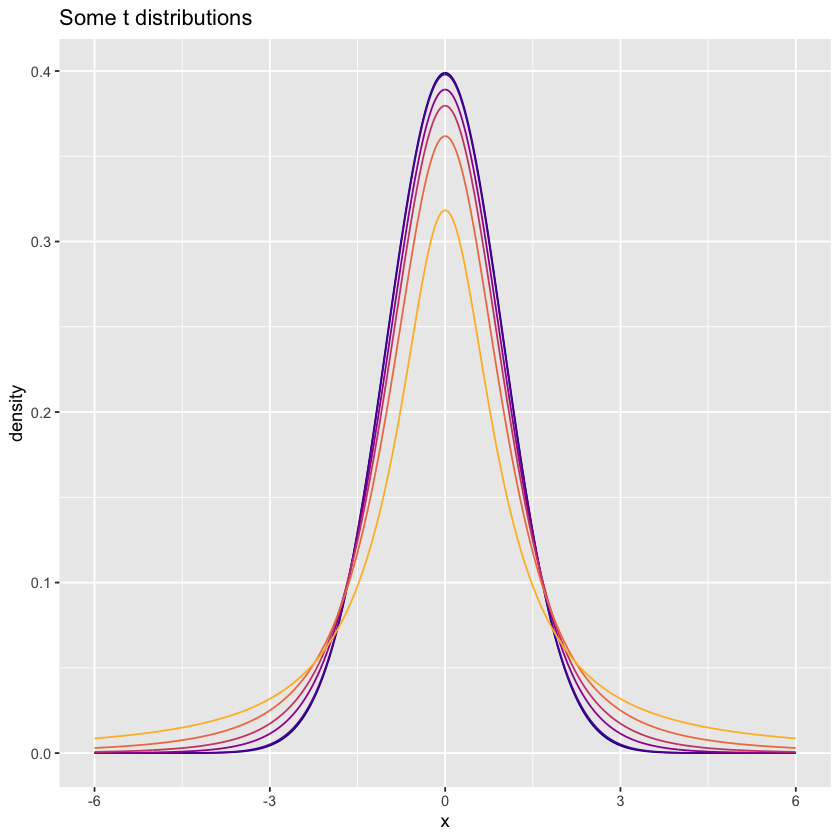

In [119]:
tibble(x = seq(from = -6, to = 6, by = .01)) %>%
  expand(x, nu = c(1, 2.5, 5, 10, 100, Inf)) %>%
  mutate(density = dt(x = x, df = nu),
         nu      = factor(nu, levels = c("Inf", "100", "10", "5", "2.5", "1"))) %>%

  ggplot(aes(x = x, y = density, group = nu, color = nu)) +
  geom_line() +
  scale_color_viridis_d(direction = 1, option = "C", end = .85) +
  labs(title = "Some t distributions") +
  theme(legend.position = "none")

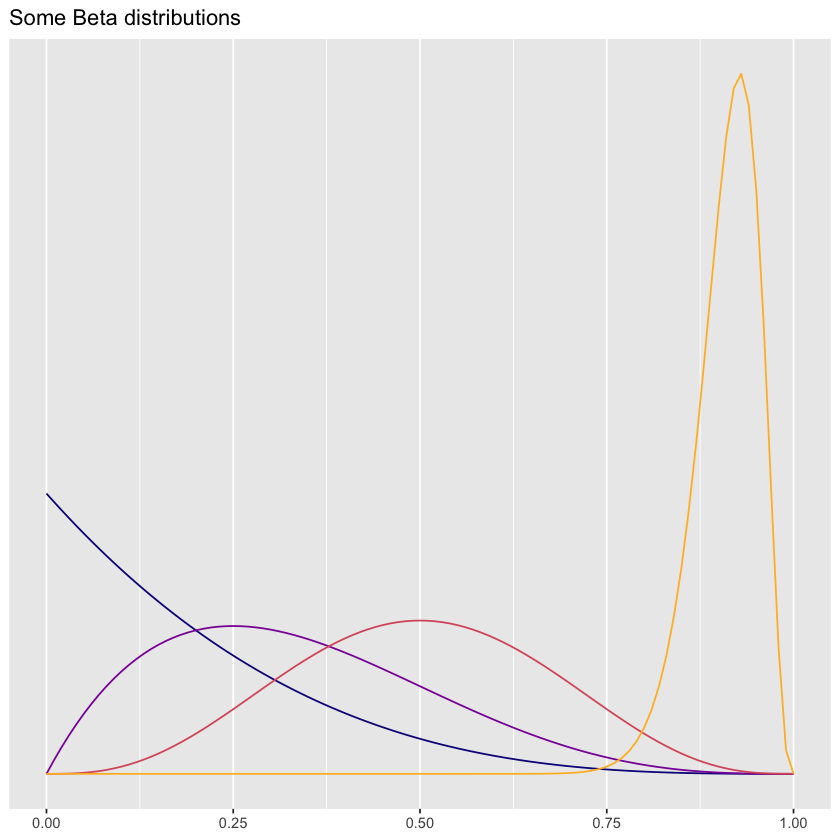

In [120]:
tibble(x = seq(from = 0, to = 1, by = .01)) %>%
  expand(x, nesting(alpha = c(1, 2, 4, 40),
                      beta  = c(4))) %>%
  mutate(density = dbeta(x = x, shape1 = alpha, shape2 = beta),
         group   = rep(letters[1:4], times = n() / 4)) %>%
  ggplot(aes(x = x, y = density, group = group, color = group)) +
  geom_line() +
  scale_color_viridis_d(direction = 1, option = "C", end = .85) +
  scale_y_continuous(NULL, breaks = NULL) +
  coord_cartesian(xlim = 0:1) +
  xlab(NULL) +
  labs(title = "Some Beta distributions") +
  theme(legend.position = "none")

## Three steps of Bayesian data analysis

According to Gelman (Bayesian data analysis):

1. Set up probability model (joint probability distribution for observed ($y$, $x$) and latent quantities $\theta$).

2. Condition on observed data: calculate posterior distribution
$P(y | \theta) \cdot p(\theta)$.

3. Evaluate model and implications of the posterior distribution.
    + How well does the model fit the data?
    + Are the substantive conclusions reasonable?
    + How sensitive are the results to the modelling assumptions?
    + Does the model need to be revised?


## Bayesian workflow

![](figures/Bayesian-workflow-1.png)


## Posterior evaluation
![](figures/Bayesian-workflow-2.png)

## Model comparison

![](figures/Bayesian-workflow-3.png)